[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/data_patch_sequential.ipynb)

# Patch Sequential

In this tutorial we will show how we can quickly perform **patch processing** using the features provided by the `kornia.augmentation.PatchSequential` API.

## Install and get data

We install Kornia and some dependencies, and download a simple data sample

In [1]:
%%capture
!wget https://tinypng.com/images/social/website.jpg -O panda.jpg

/home/edgar/software/kornia/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


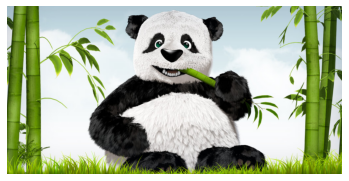

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import cv2

from kornia import augmentation as K
from kornia.augmentation import PatchSequential, ImageSequential
from kornia.geometry import bbox_to_mask
from kornia.utils import image_to_tensor, tensor_to_image
from torchvision.transforms import transforms


to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

def tensor_pre_transform_wrapper(input: torch.Tensor):
    """ A wrapper that tried to reproduce the actual output from:
        - transforms.ToPILImage()
        - transforms.ToTensor()
        For each image, simply (img * 255).int() // 255
    """
    return torch.round(input * 255).to(torch.uint8) / 255.


def plot_resulting_image(img, bbox, keypoints, mask):
    img = img * mask
    img_draw = cv2.polylines(np.array(to_pil(img)), bbox.numpy(), isClosed=True, color=(255, 0, 0))
    for k in keypoints[0]:
        img_draw = cv2.circle(img_draw, tuple(k.numpy()[:2]), radius=6, color=(255, 0, 0), thickness=-1)
    return img_draw

img = cv2.imread("panda.jpg", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

img_tensor = image_to_tensor(img).float() / 255.
plt.imshow(img); plt.axis('off');

## Patch Augmentation Sequential with patchwise_apply=True

``patchwise_apply`` is a feature that used to define unique processing pipeline for each patch location. If ``patchwise_apply=True``, the number of pipelines defined must be as same as the number of patches in an image.

/home/edgar/software/tutorials/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


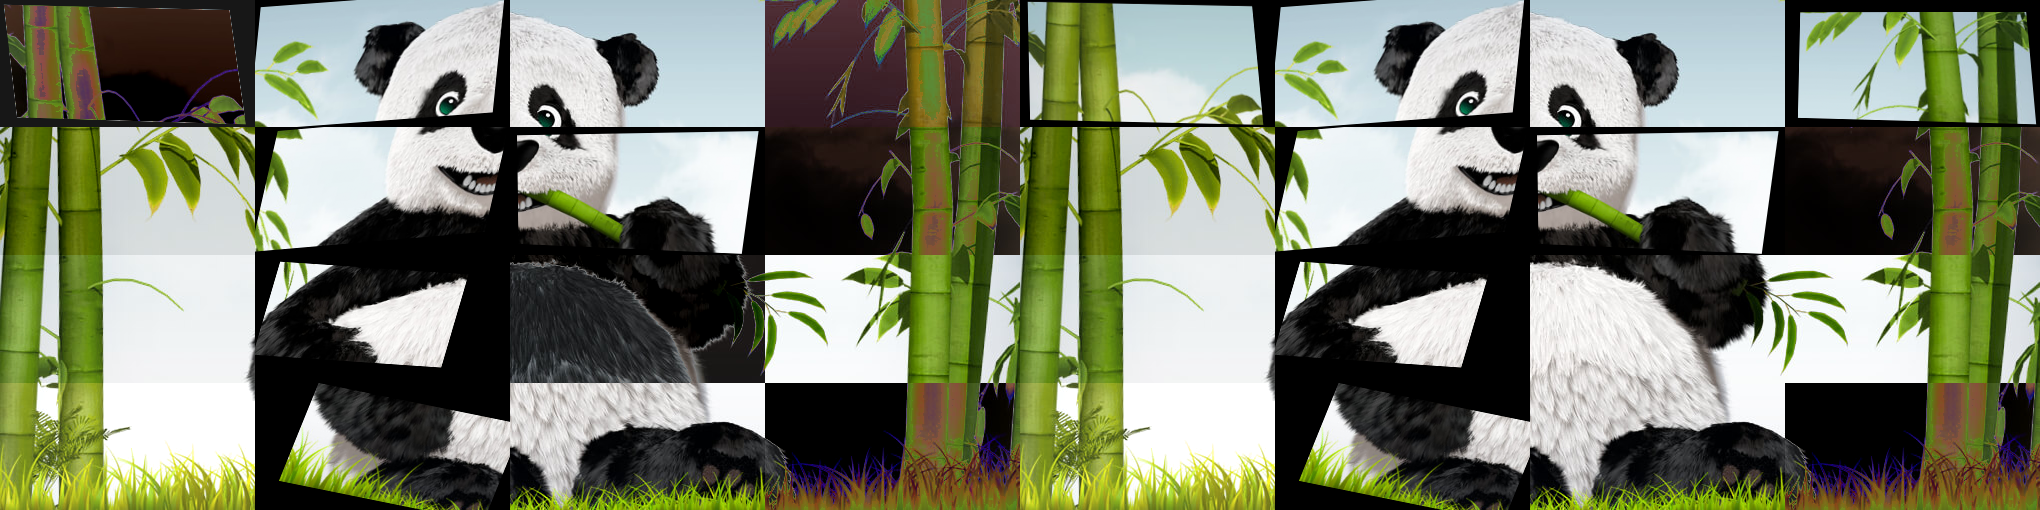

In [3]:
pseq = PatchSequential(
    ImageSequential(
        K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.5),
        K.RandomPerspective(0.2, p=0.5),
        K.RandomSolarize(0.1, 0.1, p=0.5),
    ),
    K.RandomAffine(15, [0.1, 0.1], [0.7, 1.2], [0., 20.], p=0.5),
    K.RandomPerspective(0.2, p=0.5),
    ImageSequential(
        K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.5),
        K.RandomPerspective(0.2, p=0.5),
        K.RandomSolarize(0.1, 0.1, p=0.5),
    ),
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.5),
    K.RandomAffine(15, [0.1, 0.1], [0.7, 1.2], [0., 20.], p=0.5),
    K.RandomPerspective(0.2, p=0.5),
    K.RandomSolarize(0.1, 0.1, p=0.5),
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.5),
    K.RandomAffine(15, [0.1, 0.1], [0.7, 1.2], [0., 20.], p=0.5),
    ImageSequential(
        K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.5),
        K.RandomPerspective(0.2, p=0.5),
        K.RandomSolarize(0.1, 0.1, p=0.5),
    ),
    K.RandomSolarize(0.1, 0.1, p=0.5),
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.5),
    K.RandomAffine(15, [0.1, 0.1], [0.7, 1.2], [0., 20.], p=0.5),
    K.RandomPerspective(0.2, p=0.5),
    K.RandomSolarize(0.1, 0.1, p=0.5),
    patchwise_apply=True,
    same_on_batch=True,
)
out_tensor = pseq(img_tensor[None].repeat(2, 1, 1, 1))
to_pil(torch.cat([out_tensor[0], out_tensor[1]], dim=2))

## Patch Augmentation Sequential with patchwise_apply=False

If ``patchwise_apply=False``, all the args will be combined and applied as one pipeline for each patch.

/home/edgar/software/tutorials/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


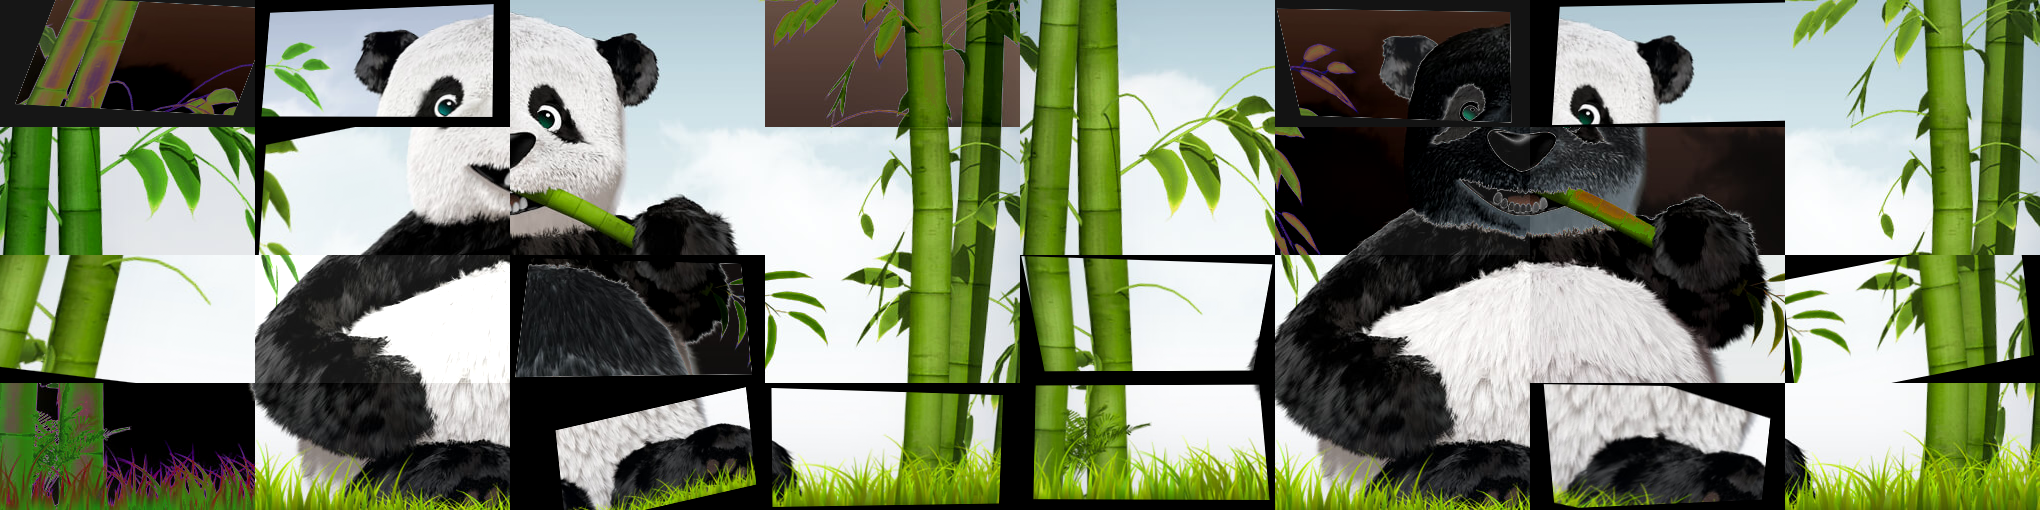

In [4]:
pseq = PatchSequential(
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.3),
    K.RandomAffine(15, [0.1, 0.1], [0.7, 1.2], [0., 20.], p=0.3),
    K.RandomPerspective(0.2, p=0.3),
    K.RandomSolarize(0.1, 0.1, p=0.1),
    patchwise_apply=False,
    same_on_batch=False
)
out_tensor = pseq(img_tensor[None].repeat(2, 1, 1, 1))
to_pil(torch.cat([out_tensor[0], out_tensor[1]], dim=2))